# Four commonly used trading strategies
1. **Classic Momentum Strategy**
2. **Classic Volatility Strategy (Low volatility long, high volatility short)**
3. **Classic Momentum Strategy with Volatility Adjusted Weights**
4. **Bet Against Beta Strategy**

## First, let's import the necessary libraries and load the data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path
import multiprocessing as mp

directory = "./data"

transacation_cost = 0.0010
N = 5

/home/vahid/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def calculate_beta(stock_returns, market_returns):
    model = sm.OLS(stock_returns, sm.add_constant(market_returns))
    results = model.fit()

    # Extract the beta
    beta = results.params.values[1]

    idio_vol = np.std(results.resid)

    return beta, idio_vol

def add_beta(ticker_data, market_data):
    period = 66
    beta_holder = {}
    iv_holder = {}

    merged_df = pd.merge(
        ticker_data['Close'],
        market_data['Close'],
        how = 'left',
        left_index=True, right_index=True,
        suffixes=('_stock', '_market')
        )
    merged_df.dropna(inplace=True)
    for i, date in enumerate(merged_df.index):
        if i < period:
            continue

        stock_returns = merged_df.iloc[i-period:i]['Close_stock'].pct_change()
        market_returns = merged_df.iloc[i-period:i]['Close_market'].pct_change()

        stock_returns.dropna(inplace=True)
        market_returns.dropna(inplace=True)

        beta, idio_vol = calculate_beta(stock_returns, market_returns)
        beta_holder[date] = beta
        iv_holder[date] = idio_vol

    beta_holder = pd.Series(beta_holder)
    beta_holder.name = 'Beta'

    beta_holder.index = pd.to_datetime(beta_holder.index, utc=True)
    beta_holder.index = beta_holder.index.tz_convert('America/Sao_Paulo')

    iv_holder = pd.Series(iv_holder)
    iv_holder.name = 'IdioVol'
    iv_holder.index = pd.to_datetime(iv_holder.index, utc=True)
    iv_holder.index = iv_holder.index.tz_convert('America/Sao_Paulo')

    # Merge the beta with the original data
    ticker_data = pd.merge(ticker_data, beta_holder, how='left', left_index=True, right_index=True)
    ticker_data = pd.merge(ticker_data, iv_holder, how='left', left_index=True, right_index=True)

    return ticker_data

# Some helper functions
def prepare_for_reg(df1, df2, name1, name2):
    
    df1 = df1.copy().values.flatten()
    df2 = df2.copy().values.flatten()
    
    df1 = pd.Series(df1, name=name1)
    df2 = pd.Series(df2, name=name2)
    
    df = pd.concat([df1, df2], axis=1)
    df = df.dropna()
    
    return df

def report_portfolio_returns(portfolio_returns, market_return, periods_in_year=12):
    
    portfolio_returns = portfolio_returns[~np.isnan(portfolio_returns)]
    
    sharpe = np.mean(portfolio_returns) / np.std(portfolio_returns) * np.sqrt(periods_in_year)
    max_drawdown = (portfolio_returns.cumsum().cummax() - portfolio_returns.cumsum()).max()
    average_annual_return = np.mean(portfolio_returns) * periods_in_year
    average_daily_return = average_annual_return / 252
    
    # Concatenate the market return with the portfolio returns
    market_return = market_return[market_return.index >= portfolio_returns.index[0]]
    
    df_for_reg = pd.concat([portfolio_returns, market_return], axis=1)
    df_for_reg.columns = ['Portfolio', 'Market']
    df_for_reg = df_for_reg.dropna()
    
    market_return = df_for_reg['Market']
    portfolio_returns = df_for_reg['Portfolio']
    
    # Find the beta
    X = sm.add_constant(market_return)
    y = portfolio_returns
    model = sm.OLS(y, X, missing='drop')
    results = model.fit()
    beta = results.params.iloc[1]
    
    print(f'Sharpe: {sharpe:2f}, MaxDD: {max_drawdown:2f}, AnnualReturn: {average_annual_return:2f}, Beta: {beta:2f}, ADR: {average_daily_return:2f}')
    
    return sharpe, max_drawdown, average_annual_return

def conduct_regression(df1, df2, name1, name2):
    
    df_for_regression = prepare_for_reg(df1, df2, name1, name2)
    
    X = sm.add_constant(df_for_regression[name1])
    y = df_for_regression[name2]
    
    model = sm.OLS(y, X)
    results = model.fit()
    
    print (results.summary())
    
def plot_returns(portfolio_returns, market_return):
    
    portfolio_returns = portfolio_returns.copy().dropna()
    market_return = market_return[market_return.index >= portfolio_returns.index[0]]
    
    plt.plot(portfolio_returns.cumsum(), label='Cumulative return')
    plt.plot((portfolio_returns - transacation_cost).cumsum(), label='Cumulative return with transaction costs')
    plt.plot(market_return.cumsum(), label='Market return')
    plt.title('Cumulative return')
    plt.legend()
    plt.show()

In [3]:
def load_data(directory, filename, market_data = None):
    
    df = pd.read_feather(os.path.join(directory, filename))
    df = df[df.index.isna() == False]
    
    if len(df) < 252 * 2:
        return None
    
    df['daily_return'] = df['Close'].pct_change(fill_method=None)
    df['volatility'] = df['daily_return'].rolling(126).std()
    
    # This is the case when we only want to load the market data
    if market_data is None:
        return df
    
    if "Beta" not in df.columns:
        df = add_beta(df, market_data)
        df.to_feather(os.path.join(directory, filename))
    
    # Convert to monthly data
    df = df.resample('ME').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',
        'daily_return': 'mean',
        'volatility': 'mean',
        'Beta': 'last',
        'IdioVol': 'last'
    })
    
    df['intra_month_return'] = df['Close'] / df['Open'] - 1
    df['next_month_return'] = df['intra_month_return'].shift(-1)
    
    df['monthly_return'] = df['Close'].pct_change(fill_method=None)
    df['rolling_12_months_return'] = df['Close'].pct_change(fill_method=None).rolling(12).sum().shift()
    
    return df

# Read the data in this directory using pd.read_feather
market = load_data(directory, 'IBOV-1d-10.feather')

# Market monthly
market_monthly = market.resample('ME').agg({'Close': 'last',})
market_monthly_return = market_monthly['Close'].pct_change(fill_method=None)

filenames_to_load = []
for filename in os.listdir(directory):
    if not filename.endswith('.feather'):
        continue
    if 'IBOV' in filename:
        continue
    filenames_to_load.append(filename)

n_cores = mp.cpu_count() - 2
with mp.Pool(n_cores) as pool:
    data_holder = pool.starmap(load_data, [(directory, filename, market) for filename in filenames_to_load])

data_holder = {filename.split('-')[0]: data for filename, data in zip(filenames_to_load, data_holder) if data is not None}
tickers = list(data_holder.keys())

In [4]:
rolling_12_months_return_holder = []
next_month_return_holder = []
monthly_return_holder = []
rolling_volatility_holder = []
beta_holder = []
idiol_vol_holder = []

# Creating tables with symbols as columns and the data as rows
first = True
for symbol, df in data_holder.items():

    rolling_12_months_return_series = df['rolling_12_months_return'].copy()
    next_month_return_series = df['next_month_return'].copy()
    monthly_return = df['monthly_return'].copy()
    rolling_volatility = df['volatility'].copy()
    beta = df['Beta'].copy()
    idio_vol = df['IdioVol'].copy()

    rolling_12_months_return_series.name = symbol
    next_month_return_series.name = symbol
    monthly_return.name = symbol
    rolling_volatility.name = symbol
    beta.name = symbol
    idio_vol.name = symbol

    rolling_12_months_return_holder.append(rolling_12_months_return_series)
    next_month_return_holder.append(next_month_return_series)
    monthly_return_holder.append(monthly_return)
    rolling_volatility_holder.append(rolling_volatility)
    beta_holder.append(beta)
    idiol_vol_holder.append(idio_vol)

rolling_12_months_return_df = pd.concat(rolling_12_months_return_holder, axis=1, ignore_index=False)
next_month_return_df = pd.concat(next_month_return_holder, axis=1, ignore_index=False)
monthly_return_df = pd.concat(monthly_return_holder, axis=1, ignore_index=False)
rolling_volatility_df = pd.concat(rolling_volatility_holder, axis=1, ignore_index=False)
betas_df = pd.concat(beta_holder, axis=1, ignore_index=False)
iv_df = pd.concat(idiol_vol_holder, axis=1, ignore_index=False)

#### Classic Momentum Strategy

                            OLS Regression Results                            
Dep. Variable:      next_month_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4429
Date:                Mon, 23 Sep 2024   Prob (F-statistic):              0.506
Time:                        08:42:53   Log-Likelihood:                 543.53
No. Observations:                1200   AIC:                            -1083.
Df Residuals:                    1198   BIC:                            -1073.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

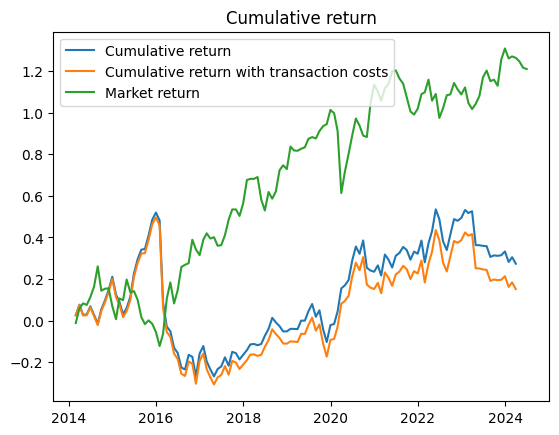

In [5]:
# Symbols to long and short
long_df = rolling_12_months_return_df[(rolling_12_months_return_df > 0)]
short_df = rolling_12_months_return_df[(rolling_12_months_return_df < 0)]

long_df = long_df.mask(long_df.rank(axis=1, method='dense', ascending=False) > N, np.nan)
short_df = short_df.mask(short_df.rank(axis=1, method='dense', ascending=True) > N, np.nan)

# Find the values of each ticker the long and short in rolling_12_months_return_df and next_month_return_df
# and flatten them for a regression
mask = long_df.notna() | short_df.notna()
rolling_12_months_return_df_for_reg = rolling_12_months_return_df[mask]
next_month_return_df_for_regression = next_month_return_df[mask]

conduct_regression(rolling_12_months_return_df_for_reg, next_month_return_df_for_regression,
                   'rolling_12_months_return', 'next_month_return')

# Keep the info for later
momentum_mask = mask.copy()
momentum_long_mask = long_df.notna().copy()
momentum_short_mask = short_df.notna().copy()

returns = next_month_return_df.copy()
returns[~mask] = np.nan
returns[short_df.notna()] = -returns[short_df.notna()]
portfolio_returns = returns.mean(axis=1, skipna=True)

print ("Without transaction costs")
sharpe, max_drawdown, average_annual_return = report_portfolio_returns(portfolio_returns, market_monthly_return)

print ("With transaction costs")
portfolio_returns = portfolio_returns - transacation_cost
sharpe, max_drawdown, average_annual_return = report_portfolio_returns(portfolio_returns, market_monthly_return)

plot_returns(portfolio_returns, market_monthly_return)

## Conclusion:
We can see that the very well knowl momentum strategy is working poorly in the brazilian market. The strategy is not even working without transaction costs.

### Second strategy: Classic Volatility Strategy (Low volatility long, high volatility short)

                            OLS Regression Results                            
Dep. Variable:      next_month_return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.603
Date:                Mon, 23 Sep 2024   Prob (F-statistic):             0.0321
Time:                        08:42:53   Log-Likelihood:                 612.46
No. Observations:                1276   AIC:                            -1221.
Df Residuals:                    1274   BIC:                            -1211.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0010      0

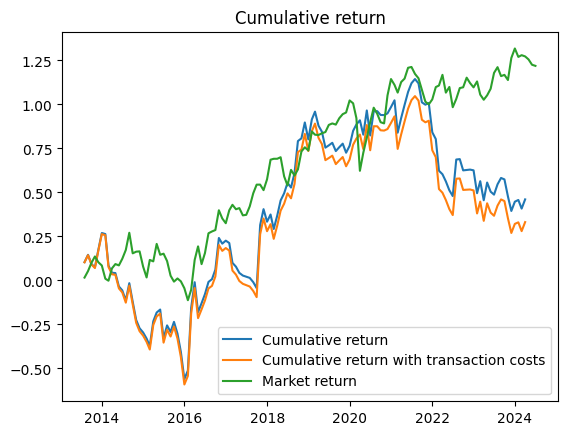

In [6]:
# Symbols to long and short
long_df = rolling_volatility_df.copy()
short_df = rolling_volatility_df.copy()

long_df = long_df.mask(long_df.rank(axis=1, method='dense', ascending=False) > N, np.nan)
short_df = short_df.mask(short_df.rank(axis=1, method='dense', ascending=True) > N, np.nan)

mask = long_df.notna() | short_df.notna()
rolling_volatility_df_for_ref = rolling_volatility_df[mask]
next_month_return_df_for_reg = next_month_return_df[mask]

conduct_regression(
    rolling_volatility_df_for_ref, next_month_return_df_for_reg,
    'rolling_volatility', 'next_month_return'
)

returns = next_month_return_df.copy()
returns[~mask] = np.nan
returns[short_df.notna()] = -returns[short_df.notna()]
amr_before = returns.mean(axis=1, skipna=True).mean()

sum_of_volatility = (1/rolling_volatility_df[mask]).sum(axis=1)
returns = returns * (1/rolling_volatility_df).div(sum_of_volatility, axis=0)
amr_after = returns.mean(axis=1, skipna=True).mean()

# There's a slight look-ahead bias here, but it's not significant
# I am adjusting the adjusted monthly return to the average monthly return before the adjustment
returns = returns * amr_before / amr_after

portfolio_returns = returns.mean(axis=1, skipna=True)

print("Without transaction costs")
sharpe, max_drawdown, average_annual_return = report_portfolio_returns(portfolio_returns, market_monthly_return)

print ("With transaction costs")
portfolio_returns = portfolio_returns - transacation_cost
sharpe, max_drawdown, average_annual_return = report_portfolio_returns(portfolio_returns, market_monthly_return)

plot_returns(portfolio_returns, market_monthly_return)

### Third strategy: Classic Momentum Strategy with Volatility Adjusted Weights

Without transaction costs
Sharpe: 0.344287, MaxDD: 0.327597, AnnualReturn: 0.068057, Beta: -0.025890, ADR: 0.000270
With transaction costs
Sharpe: 0.283581, MaxDD: 0.329597, AnnualReturn: 0.056057, Beta: -0.025890, ADR: 0.000222


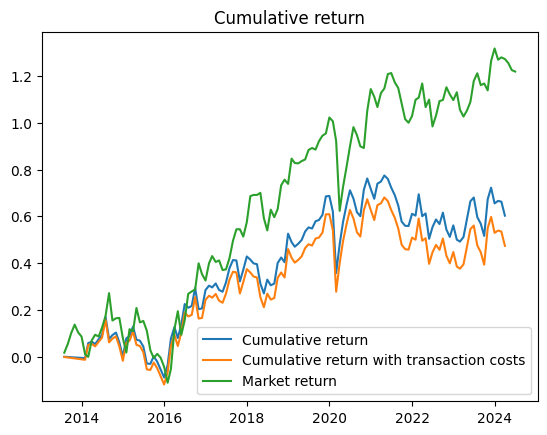

In [7]:
returns = next_month_return_df.copy()
returns = returns[~momentum_mask]
returns[momentum_short_mask] = -returns[momentum_short_mask]
amr_before = returns.mean(axis=1, skipna=True).mean()

sum_of_volatility = (1/(rolling_volatility_df[momentum_mask]).sum(axis=1) + 1e-6)
returns = returns * (1/rolling_volatility_df).div(sum_of_volatility, axis=0)
amr_after = returns.mean(axis=1, skipna=True).mean()

# There's a slight look-ahead bias here, but it's not significant
returns = returns * amr_before / amr_after

print ("Without transaction costs")
portfolio_returns = returns.mean(axis=1, skipna=True)
sharpe, max_drawdown, average_annual_return = report_portfolio_returns(portfolio_returns, market_monthly_return)

print ("With transaction costs")
portfolio_returns = portfolio_returns - transacation_cost
sharpe, max_drawdown, average_annual_return = report_portfolio_returns(portfolio_returns, market_monthly_return)

plot_returns(portfolio_returns, market_monthly_return)
momentum_with_volatility_adjusted_portfolio_returns = portfolio_returns.copy()

### Fourth strategy: Bet Against Beta Strategy

                            OLS Regression Results                            
Dep. Variable:      next_month_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5362
Date:                Mon, 23 Sep 2024   Prob (F-statistic):              0.464
Time:                        08:42:53   Log-Likelihood:                 660.74
No. Observations:                1312   AIC:                            -1317.
Df Residuals:                    1310   BIC:                            -1307.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.006      0.543      0.5

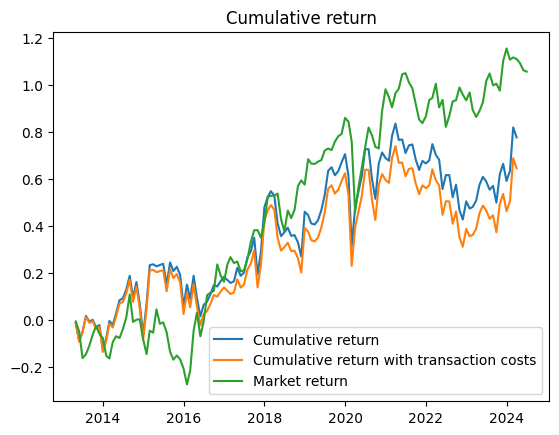

In [8]:
long_df = betas_df[betas_df > 0].copy()
short_df = betas_df[betas_df > 0].copy()

long_df = long_df.mask(long_df.rank(axis=1, method='dense', ascending=False) > N, np.nan)
short_df = short_df.mask(short_df.rank(axis=1, method='dense', ascending=True) > N, np.nan)

mask = long_df.notna() | short_df.notna()
betas_df_for_reg = betas_df[mask]
next_month_return_df_for_reg = next_month_return_df[mask]

conduct_regression(betas_df_for_reg, next_month_return_df_for_reg, 'Beta', 'next_month_return')

returns = next_month_return_df.copy()
returns[~mask] = np.nan
amr_before = returns.mean(axis=1, skipna=True).mean()

beta_adjuster = betas_df.copy()
betas_adjuster = beta_adjuster.clip(0.1, 10)

sum_of_beta = (1/betas_adjuster[mask]).sum(axis=1)
returns = returns * (1/betas_adjuster).div(sum_of_beta, axis=0)
amr_after = returns.mean(axis=1, skipna=True).mean()

# There's a slight look-ahead bias here, but it's not significant
returns = returns * amr_before / amr_after

portfolio_returns = returns.mean(axis=1, skipna=True)

print ("Without transaction costs")
sharpe, max_drawdown, average_annual_return = report_portfolio_returns(portfolio_returns, market_monthly_return)

print ("With transaction costs")
portfolio_returns = portfolio_returns - transacation_cost
sharpe, max_drawdown, average_annual_return = report_portfolio_returns(portfolio_returns, market_monthly_return)

plot_returns(portfolio_returns, market_monthly_return)

bet_against_beta_portfolio_returns = portfolio_returns.copy()

# Fifth Strategy: IdioVolatility based

                            OLS Regression Results                            
Dep. Variable:      next_month_return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.731
Date:                Mon, 23 Sep 2024   Prob (F-statistic):             0.0987
Time:                        08:42:53   Log-Likelihood:                 679.12
No. Observations:                1306   AIC:                            -1354.
Df Residuals:                    1304   BIC:                            -1344.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.007     -0.393      0.6

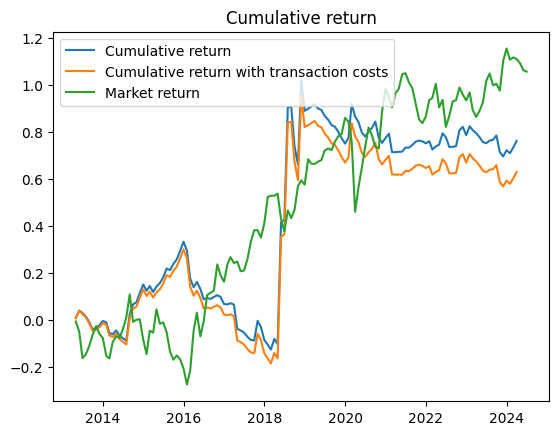

In [9]:
long_df = iv_df.copy()
short_df = iv_df.copy()

long_df = long_df.mask(long_df.rank(axis=1, method='dense', ascending=False) > N, np.nan)
short_df = short_df.mask(short_df.rank(axis=1, method='dense', ascending=True) > N, np.nan)

mask = long_df.notna() | short_df.notna()
iv_df_for_reg = iv_df[mask]
next_month_return_df_for_reg = next_month_return_df[mask]

conduct_regression(iv_df_for_reg, next_month_return_df_for_reg, 'IdioVol', 'next_month_return')

returns = next_month_return_df.copy()
returns[~mask] = np.nan
amr_before = returns.mean(axis=1, skipna=True).mean()

iv_adjuster = betas_df.copy()

sum_of_iv = (1/iv_adjuster[mask]).sum(axis=1)
returns = returns * (1/iv_adjuster).div(sum_of_iv, axis=0)

amr_after = returns.mean(axis=1, skipna=True).mean()

# There's a slight look-ahead bias here, but it's not significant
returns = returns * amr_before / amr_after

portfolio_returns = returns.mean(axis=1, skipna=True)

print ("Without transaction costs")
sharpe, max_drawdown, average_annual_return = report_portfolio_returns(portfolio_returns, market_monthly_return)

print ("With transaction costs")
portfolio_returns = portfolio_returns - transacation_cost
sharpe, max_drawdown, average_annual_return = report_portfolio_returns(portfolio_returns, market_monthly_return)

plot_returns(portfolio_returns, market_monthly_return)

Without transaction costs
Sharpe: 0.317327, MaxDD: 0.360807, AnnualReturn: 0.066509, Beta: 0.036183, ADR: 0.000264
With transaction costs
Sharpe: 0.260073, MaxDD: 0.362807, AnnualReturn: 0.054509, Beta: 0.036183, ADR: 0.000216


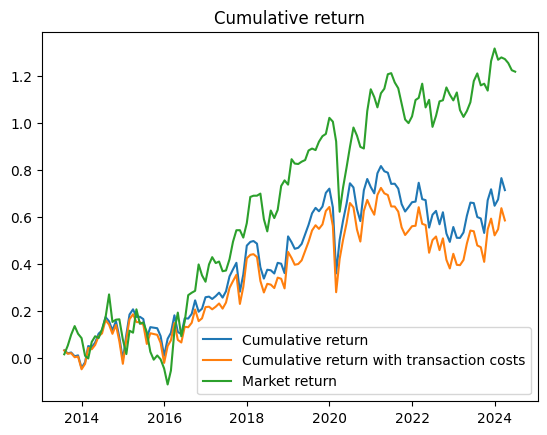

In [10]:
p = (momentum_with_volatility_adjusted_portfolio_returns + bet_against_beta_portfolio_returns)/2

print ("Without transaction costs")
sharpe, max_drawdown, average_annual_return = report_portfolio_returns(p, market_monthly_return)

print ("With transaction costs")
sharpe, max_drawdown, average_annual_return = report_portfolio_returns(p - transacation_cost, market_monthly_return)

plot_returns(p, market_monthly_return)